# CVRP Notebook
This notebook is intended to run the top level code for the CVRP

In [1]:
import networkx as nx

from src.model import VRP, create_constraints, output_variables, create_example_2
from src.pricer import VRPPricer
from src.parse import parse_graph
from src.output import write_solution

from matplotlib import pyplot as plt
import matplotlib

Uncomment the line of the instance, which you want to use.
The Uchoa instances require an additional K parameter for the convexity constraint, as the dataset does not provide it.
Usually the k of the instance name is a good guess, as it is the minimum number of vehicles in any feasible soltuion.
E.g. for X-n106-k14 calling `G = parse_graph("X-n106-k14",14)` works.

A folder `output` is required, as the log will be placed there.
( This location can be changed by using the filename parameter)
The log contains all information regarding the solution process of the instance.

In [2]:
# G = parse_graph("E-n22-k4")
# G = parse_graph("E-n23-k3")
# G = parse_graph("E-n30-k3")
# G = parse_graph("E-n33-k4")
# G = parse_graph("E-n51-k5")
# G = parse_graph("E-n76-k14",filename="output/E-n76-k14.debug")
# G = parse_graph("E-n101-k14",filename="output/E-n101-k14.debug")
# G = parse_graph("X-n101-k25",26)
G = parse_graph("X-n106-k14",14)

MAIN: Instance X-n106-k14
PARSE: There is no minimum number of trucks.
PARSE: Using the provided K = 14
PARSE: Writing to file output/X-n106-k14_5.log


In [4]:
model = VRP(G)

pricer = VRPPricer(G)
# desribes, which method will be used. Options are ['ESPPRC',"SPPRC",'cyc2','ngX'], where X can be any integer
# Also multiple methods can be given as argument, then every pricing algorithm will be called subsequently
# but only the routes of the first one will be added
# E.g. pricer.data['methods'] = ["ng8","SPPRC"]
pricer.data['methods'] = ["ng8"]

# Determines, whether the heuristic of chapter A.5 be
pricer.data["ESPPRC_heur"] = True
# Maximum number of variables added after each pricing round
pricer.data['max_vars']= int(1e2)
pricer.data['time_limit'] = 11000
# Determines, whether the Farley Labelling algorithm will be called after each exact pricing round.
# Requires the use of ng Paths as a method 
pricer.data['farley'] = False

model.includePricer(pricer, "pricer","does pricing")

# The heuristic parameters determine the use of the Vidal heuristic
# heuristic_time is the time of each call to this heuristc
# heuristic_stale_it is a feature to early abort these heuristic calls, of no new route has been 
# added in heuristic_stale_it number of iterations
create_constraints(model,pricer,heuristic_stale_it=20, heuristic_max_it=2, heuristic_time=1)

model.optimize()
model.hideOutput(quiet=False)

write_solution(model, pricer)

HYGESE: Found 27 initial routes in 2 rounds. Best sol val is 26426.0
SETUP: methods are ['SPPRC']
SETUP: time_limit is 11000
SETUP: Farley is False
PRICER_PY: The maximal path length is 14
PRICER_PY: The neighborhood has been initialized to [] neighbors.
PRICER_C: Graph data successfully copied to C.
presolving:
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 132 variables (0 bin, 0 int, 0 impl, 132 cont) and 106 constraints
    106 constraints of type <linear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
* 0.2s|     1 |     0 |    36 |     - |    LP  |   0 | 132 | 106 | 106 |   0 |  0 |   0 |   0 |      --      | 2.641400e+04 |    Inf | unknown
  0.2s|     1 |     0 |    44 |  

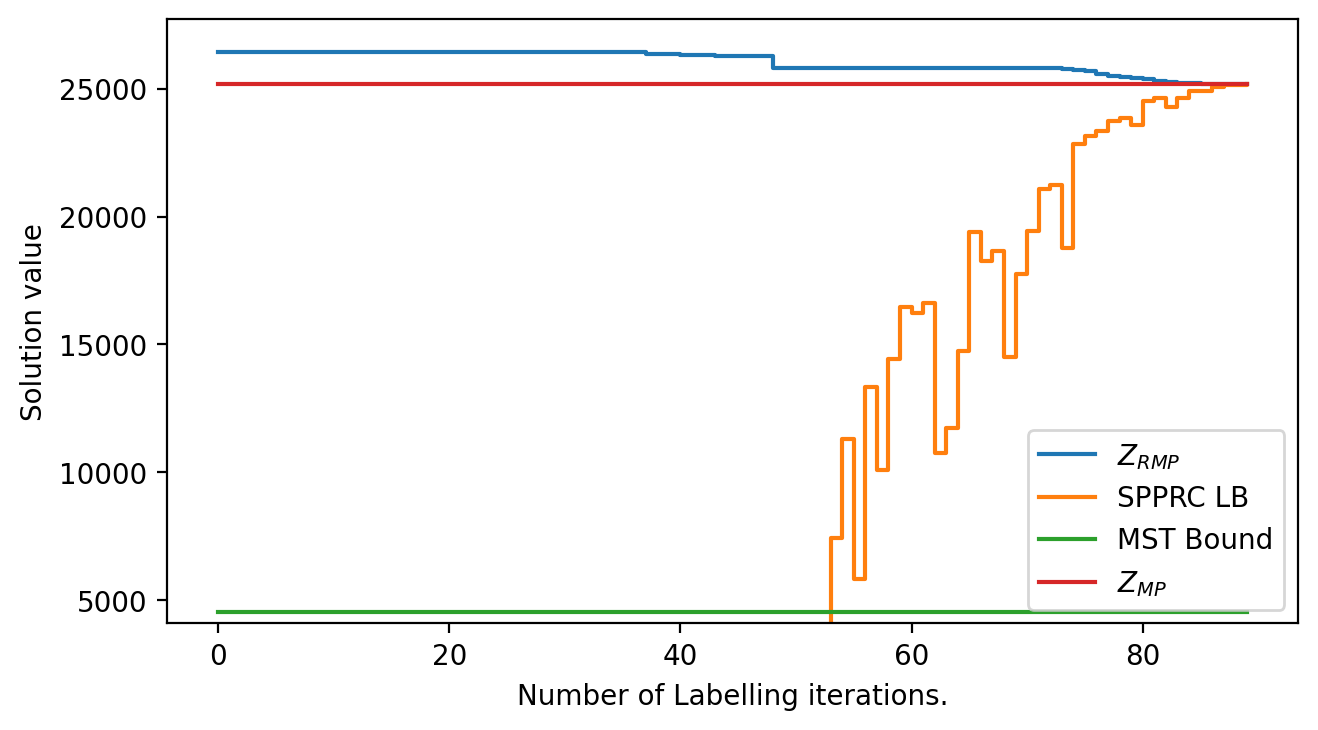

In [13]:
# This value is nice looking for the standard latex layout
# plt.figure(figsize=(6.6,4),dpi=100)

# This value is nice looking for the CoAn layout
plt.figure(figsize=(7.3,4),dpi=200)

# This value is the original value for the presentation but looks horrible
# plt.figure(figsize=(4.5,2.5),dpi=200)

upper_bounds = [x for x,y in pricer.data['bounds'][pricer.data['methods'][0]]]
plt.plot(upper_bounds, label="$Z_{\mathit{RMP}}$", ds='steps-post')

xmax = 0
for method in pricer.data['methods']:
    lower_bounds = [lb for _,lb in pricer.data['bounds'][method]]
#     lower_bounds = []
#     best_lb = pricer.data['bounds'][method][0][1]
#     for x,y in pricer.data['bounds'][method]:
#         if y > best_lb:
#             best_lb = y
#         lower_bounds.append(best_lb)
    plt.plot(lower_bounds, label=f'{method} LB', ds='steps-post')
    xmax = max(upper_bounds[0],xmax)

T = nx.minimum_spanning_tree(G)
K = G.graph['min_trucks']
lowest_remaining_edge_weights = [weight for u,v,weight in G.edges().data('weight') if not T.has_edge(u,v)]
mst = T.size(weight='weight') + sum(sorted(lowest_remaining_edge_weights)[:K])
mst = [mst for i in range(len(upper_bounds))]
plt.plot(mst, label="MST Bound")

if pricer.data['farley']:
    farley_bounds = pricer.data['farley_bound']
    plt.plot(farley_bounds, label="Farley Bound")

solval = model.getObjVal()
sol = [solval for i in range(len(upper_bounds))]
plt.plot(sol,label="$Z_{MP}$")

plt.ylim((mst[0]*0.9,solval*1.1))

plt.legend(loc='lower right')
plt.xlabel("Number of Labelling iterations.")
plt.ylabel("Solution value")

plt.show()

In [14]:
output_variables(model, pricer)

The solution contains the following paths: 
Only paths with associated value larger than 1e-06 are analysed.
0.39480651984965276 * t_x127: (0, 26, 7, 75, 84, 9, 12, 24, 0)
The following path is non elementary
0.015281942873819003 * x6069: (0, 63, 94, 64, 94, 64, 94, 64, 94, 64, 94, 63, 0)
The following path is non elementary
0.05019509728387092 * x6298: (0, 102, 92, 102, 92, 102, 92, 102, 92, 0)
The following path is non elementary
0.18312238451771984 * x7289: (0, 34, 99, 11, 99, 11, 34, 53, 0)
The following path is non elementary
0.2 * x7318: (0, 45, 100, 45, 100, 45, 100, 45, 100, 45, 0)
The following path is non elementary
0.03910298450931285 * x7395: (0, 25, 39, 50, 39, 50, 39, 61, 56, 0)
The following path is non elementary
0.13770098750839962 * x7406: (0, 48, 8, 36, 8, 36, 8, 36, 8, 48, 0)
The following path is non elementary
0.010421560214935888 * x7508: (0, 48, 2, 48, 2, 48, 2, 48, 2, 48, 2, 0)
The following path is non elementary
0.5 * x7552: (0, 33, 62, 26, 62, 52, 33, 22, 0)